In [38]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import glob
import pydicom

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torch.utils.data import Dataset, DataLoader

In [ ]:
# !pip install -q super_gradients==3.6.0

In [5]:
stdout = sys.stdout

from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

sys.stdout = stdout

In [6]:
!pwd

/Users/dmtragfnv/hackathons/int20h_2024/INT20H_RSNA_Pneumonia_Detection_4NN/Notebooks


In [7]:
!ls

data_generator.ipynb
detection_how_to_connect_custom_dataset.ipynb
example_data
exploratory-data-analysis.ipynb
lung-opacity-overview.ipynb


In [8]:
%cd ../

/Users/dmtragfnv/hackathons/int20h_2024/INT20H_RSNA_Pneumonia_Detection_4NN


In [9]:
DATA_DIR = 'Data'

train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')
annotation_metadata_dir = os.path.join(DATA_DIR, 'image_bbox_full.csv')

In [83]:
metadata_df = pd.read_csv(annotation_metadata_dir)
metadata_df.head()

,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../Data/stage_2_train_images/0004cfab-14fd-4e4...
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../Data/stage_2_train_images/000924cf-0f8d-42b...
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...
3,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...
4,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../Data/stage_2_train_images/000fe35a-2649-43d...


In [84]:
metadata_df.loc[:, "coords"] = metadata_df.loc[:, ["Target", "x", "y", "width", "height"]].values.tolist()
metadata_df.head()

,patientId,x,y,width,height,Target,class,boxes,path,coords
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../Data/stage_2_train_images/0004cfab-14fd-4e4...,"[0.0, nan, nan, nan, nan]"
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../Data/stage_2_train_images/000924cf-0f8d-42b...,"[0.0, nan, nan, nan, nan]"
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...,"[1.0, 316.0, 318.0, 170.0, 478.0]"
3,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...,"[1.0, 660.0, 375.0, 146.0, 402.0]"
4,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../Data/stage_2_train_images/000fe35a-2649-43d...,"[1.0, 570.0, 282.0, 269.0, 409.0]"


In [94]:
metadata_df.loc[:, "patientId"].nunique(), \
    metadata_df.loc[metadata_df["Target"] != 0, "patientId"].nunique(), \
    metadata_df.loc[metadata_df["Target"] == 0, "patientId"].nunique()

(26684, 6012, 20672)

In [9]:
# def func(x):
#     if x.shape[0] > 1:
#         return list(x)
#     else:
#         return x

# metadata_df.groupby("patientId")["coords"].agg(func)

In [10]:
grouped_bbox = metadata_df.groupby("patientId")["coords"].agg(list).to_frame()
grouped_bbox

,coords
patientId,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,"[[0.0, nan, nan, nan, nan]]"
000924cf-0f8d-42bd-9158-1af53881a557,"[[0.0, nan, nan, nan, nan]]"
000db696-cf54-4385-b10b-6b16fbb3f985,"[[1.0, 316.0, 318.0, 170.0, 478.0], [1.0, 660...."
000fe35a-2649-43d4-b027-e67796d412e0,"[[1.0, 570.0, 282.0, 269.0, 409.0], [1.0, 83.0..."
001031d9-f904-4a23-b3e5-2c088acd19c6,"[[1.0, 66.0, 160.0, 373.0, 608.0], [1.0, 552.0..."
...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,"[[1.0, 177.0, 285.0, 225.0, 529.0], [1.0, 641...."
fffba05a-1635-4545-9bbd-57ad4cfe8d27,"[[0.0, nan, nan, nan, nan]]"
fffc95b5-605b-4226-80ab-62caec682b22,"[[0.0, nan, nan, nan, nan]]"


In [11]:
metadata_storage = {}

for ind, bbox_values in grouped_bbox.iterrows():
    curr_img_id = os.path.join(train_dicom_dir, f"{ind}.dcm")
    if os.path.isfile(curr_img_id):
        metadata_storage[curr_img_id] = bbox_values.values[0]

In [12]:
len(metadata_storage.keys())

26684

In [378]:
# metadata_storage

In [14]:
len(metadata_storage)

26684

In [10]:
def read_meatadata_frame(annotation_directory):
    assert os.path.isfile(annotation_directory), f"No metadata into following dir: {annotation_directory}"

    return pd.read_csv(annotation_directory)


def construct_metadata_df(annotation_directory):
    annotations_df_ = read_meatadata_frame(annotation_directory)
    annotations_df_.loc[:, "coords"] = \
        annotations_df_.loc[:, ["Target", "x", "y", "width", "height"]].values.tolist()
    grouped_bbox_df = annotations_df_.groupby("patientId")["coords"].agg(list).to_frame()
    
    return grouped_bbox_df


def split_train_val(grouped_bbox_df, val_size=0.15):
    val_set = grouped_bbox_df.sample(frac=val_size)    
    train_set = grouped_bbox_df.loc[~grouped_bbox_df.index.isin(val_set.index)]
        
    return train_set, val_set
    
    
def construct_metadata_storage(grouped_bbox_df, data_directory):
    metadata_storage = {}
    for ind, bbox_values in grouped_bbox_df.iterrows():
        curr_img_id = os.path.join(data_directory, f"{ind}.dcm")
        if os.path.isfile(curr_img_id):
            metadata_storage[curr_img_id] = bbox_values.values[0]

    return metadata_storage

In [11]:
grouped_bbox_df = construct_metadata_df(annotation_metadata_dir)

train_grouped_bbox_df, val_grouped_bbox_df = split_train_val(grouped_bbox_df)

train_metadata_storage = construct_metadata_storage(train_grouped_bbox_df, train_dicom_dir)
val_metadata_storage = construct_metadata_storage(val_grouped_bbox_df, train_dicom_dir)

In [12]:
len(train_metadata_storage.keys()), len(val_metadata_storage.keys())

(22681, 4003)

In [303]:
class CustomImageDataset(Dataset):
    def __init__(self, metadata_storage, transform=None, target_transform=None):
        self.metadata_storage = metadata_storage
        self.transform = transform
        self.target_transform = target_transform
    
    
    def load_bbox(self, idx):
        return np.asarray(list(self.metadata_storage.items())[idx][1])
    
    
    def load_dicom_file_as_image(self, idx, three_channel=True):
        dcm_path = list(self.metadata_storage.items())[idx][0]
        dcm_data = pydicom.read_file(dcm_path)
        image = dcm_data.pixel_array
        
        if three_channel:
            return np.stack([image] * 3, axis=2)
        else:
            return image

        
    def __len__(self):
        return len(self.metadata_storage)
    

    def __getitem__(self, idx):
        three_channel_image = self.load_dicom_file_as_image(idx)
        three_channel_image = torch.tensor(three_channel_image, dtype=torch.int16) #.permute(2, 0, 1).float()
        
        label = np.asarray(list(self.metadata_storage.items())[idx][1])
    
        if self.transform:
            three_channel_image = self.transform(three_channel_image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return three_channel_image, label
    

In [304]:
# metadata_df = pd.read_csv(annotation_metadata_dir)

train_dataset = CustomImageDataset(
    metadata_storage=train_metadata_storage
)

val_dataset = CustomImageDataset(
    metadata_storage=val_metadata_storage
)

In [322]:
len(train_dataset.metadata_storage.keys()), len(val_dataset.metadata_storage.keys()), 

(22681, 4003)

In [305]:
train_dataset[1][0].shape

torch.Size([1024, 1024, 3])

In [306]:
train_dataset.load_dicom_file_as_image(2).shape

(1024, 1024, 3)

In [315]:
(train_dataset.load_dicom_file_as_image(1) == train_dataset[1][0].numpy()).all()

True

In [317]:
def plot_dicom(image_data, bbox_data):
    plt.imshow(image_data)
    bounding_boxes = bbox_data

    ax = plt.gca()

    for bbox in bounding_boxes:
        class_, xmin, ymin, width, height = bbox
        rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

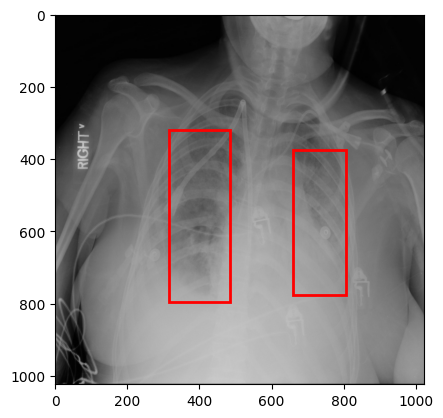

In [319]:
plot_dicom(
    train_dataset.load_dicom_file_as_image(1), train_dataset.load_bbox(1)
)

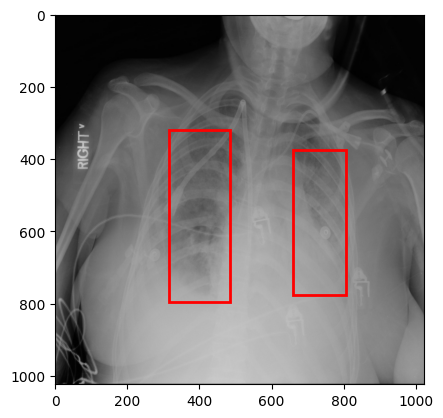

In [321]:
plot_dicom(
    train_dataset[1][0], train_dataset[1][1]
)

In [272]:
# train_dataset[0][0]

In [273]:
# train_dataset[0][1]

In [274]:
# torch.sum(train_dataset[1][0], axis=1)

In [323]:
train_dataloader = DataLoader(
    train_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN()
)

val_dataloader = DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN()
)

In [324]:
curr_batch = next(iter(train_dataloader))

In [325]:
curr_batch[0][1].shape, train_dataset[1][0].shape

(torch.Size([3, 1024, 1024]), torch.Size([1024, 1024, 3]))

In [326]:
curr_batch[0][1]

tensor([[[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
         [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
         [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
         ...,
         [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
         [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
         [ 27.,  49.,  37.,  ...,  64.,  75.,  36.]],

        [[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
         [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
         [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
         ...,
         [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
         [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
         [ 27.,  49.,  37.,  ...,  64.,  75.,  36.]],

        [[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
         [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
         [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
         ...,
         [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
         [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
         [ 27.,  49.,  37.,  ...,  64.,  75.,  36.]]]

In [327]:
### Reshaping caused by *collate_fn=DetectionCollateFN()*

# https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/utils/collate_fn/detection_collate_fn.py#L28

In [328]:
images_batch_stack = torch.stack([train_dataset[1][0]], 0)
images_batch_stack.shape

torch.Size([1, 1024, 1024, 3])

In [329]:
images_batch_stack.shape[3] == 3

True

In [330]:
test_reshape = torch.moveaxis(images_batch_stack, -1, 1).float()
test_reshape

tensor([[[[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
          [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
          [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
          ...,
          [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
          [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
          [ 27.,  49.,  37.,  ...,  64.,  75.,  36.]],

         [[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
          [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
          [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
          ...,
          [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
          [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
          [ 27.,  49.,  37.,  ...,  64.,  75.,  36.]],

         [[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
          [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
          [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
          ...,
          [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
          [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
          [ 27.,  49.,  37.,  ...

In [331]:
# inverse reshaping
torch.moveaxis(test_reshape, 1, -1).float()

tensor([[[[  1.,   1.,   1.],
          [  1.,   1.,   1.],
          [  2.,   2.,   2.],
          ...,
          [  2.,   2.,   2.],
          [  1.,   1.,   1.],
          [  0.,   0.,   0.]],

         [[  2.,   2.,   2.],
          [  2.,   2.,   2.],
          [  2.,   2.,   2.],
          ...,
          [  4.,   4.,   4.],
          [  3.,   3.,   3.],
          [  2.,   2.,   2.]],

         [[  2.,   2.,   2.],
          [  3.,   3.,   3.],
          [  3.,   3.,   3.],
          ...,
          [  5.,   5.,   5.],
          [  4.,   4.,   4.],
          [  3.,   3.,   3.]],

         ...,

         [[ 52.,  52.,  52.],
          [ 80.,  80.,  80.],
          [ 62.,  62.,  62.],
          ...,
          [140., 140., 140.],
          [143., 143., 143.],
          [ 80.,  80.,  80.]],

         [[ 60.,  60.,  60.],
          [ 88.,  88.,  88.],
          [ 72.,  72.,  72.],
          ...,
          [136., 136., 136.],
          [138., 138., 138.],
          [ 84.,  84.,  84.]],



In [340]:
torch.moveaxis(test_reshape, 1, -1).float().shape

torch.Size([1, 1024, 1024, 3])

In [332]:
(train_dataset[1][0] == torch.moveaxis(test_reshape, 1, -1).float()).all()

tensor(True)

In [364]:
def collate_required_reshape(img):
    images_batch_stack = torch.stack([img], 0)
    if images_batch_stack.shape[3] == 3:
        return torch.moveaxis(images_batch_stack, -1, 1).float()
    else:
        raise Exception(f"Invalid shape: {images_batch_stack.shape}")
        
def inverse_collate_required_reshape(transformed_img):
    return torch.moveaxis(test_reshape, 1, -1) #.float()


In [365]:
backwards_reshape(train_dataset[1][0])

tensor([[[[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
          [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
          [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
          ...,
          [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
          [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
          [ 27.,  49.,  37.,  ...,  64.,  75.,  36.]],

         [[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
          [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
          [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
          ...,
          [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
          [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
          [ 27.,  49.,  37.,  ...,  64.,  75.,  36.]],

         [[  1.,   1.,   2.,  ...,   2.,   1.,   0.],
          [  2.,   2.,   2.,  ...,   4.,   3.,   2.],
          [  2.,   3.,   3.,  ...,   5.,   4.,   3.],
          ...,
          [ 52.,  80.,  62.,  ..., 140., 143.,  80.],
          [ 60.,  88.,  72.,  ..., 136., 138.,  84.],
          [ 27.,  49.,  37.,  ...

In [367]:
(inverse_collate_required_reshape(backwards_reshape(train_dataset[1][0])) == train_dataset[1][0]) \
    .all()

tensor(True)

In [333]:
curr_batch[1]

tensor([[  0.,   0.,  nan,  nan,  nan,  nan],
        [  1.,   1., 316., 318., 170., 478.],
        [  1.,   1., 660., 375., 146., 402.],
        [  2.,   1., 570., 282., 269., 409.],
        [  2.,   1.,  83., 227., 296., 438.],
        [  3.,   1.,  66., 160., 373., 608.],
        [  3.,   1., 552., 164., 376., 676.],
        [  4.,   0.,  nan,  nan,  nan,  nan],
        [  5.,   1., 198., 375., 114., 206.],
        [  6.,   1., 161., 230., 223., 486.],
        [  6.,   1., 575., 232., 246., 528.],
        [  7.,   0.,  nan,  nan,  nan,  nan],
        [  8.,   0.,  nan,  nan,  nan,  nan],
        [  9.,   0.,  nan,  nan,  nan,  nan],
        [ 10.,   0.,  nan,  nan,  nan,  nan],
        [ 11.,   0.,  nan,  nan,  nan,  nan],
        [ 12.,   0.,  nan,  nan,  nan,  nan],
        [ 13.,   1., 562., 152., 256., 453.],
        [ 13.,   1., 264., 152., 213., 379.],
        [ 14.,   0.,  nan,  nan,  nan,  nan],
        [ 15.,   0.,  nan,  nan,  nan,  nan]], dtype=torch.float64)

In [375]:
curr_batch[1][curr_batch[1][:, 0] == 1, 1:]

tensor([[  1., 316., 318., 170., 478.],
        [  1., 660., 375., 146., 402.]], dtype=torch.float64)

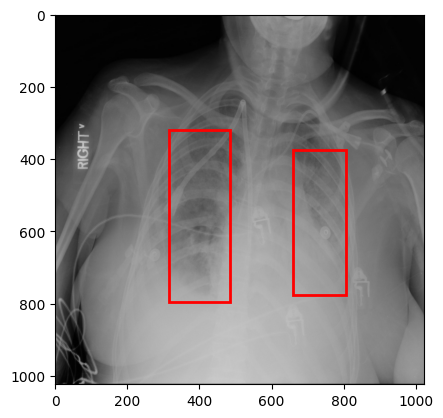

In [377]:
plot_dicom(
    inverse_collate_required_reshape(curr_batch[0][1])[0].int(), 
    curr_batch[1][curr_batch[1][:, 0] == 1, 1:]
)